# Canny边缘检测算法

In [29]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import numpy, scipy, scipy.ndimage
from scipy.ndimage import filters
from scipy.ndimage import measurements
from numpy import *
from PIL import Image, ImageFilter

In [21]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [22]:
# 梯度计算
# Sobel or Prewit gradient
def gradient(image, type=0):
    if type==0:
        Ix = filters.sobel(image, axis=1)
        Iy = filters.sobel(image, axis=0)
        return Ix, Iy
    else:
        Ix = filters.prewitt(image, axis=1)
        Iy = filters.prewitt(image, axis=0)
    return Ix, Iy

# gradient magnitudes and directions of a grayscale image, Gd: [-pi/2, +pi/2]
def gray_gradient(image):
    Gx, Gy = gradient(image)
    Gm = sqrt(Gx**2+Gy**2)
    Gd = arctan2(Gy, Gx)    
    Gd[Gd > 0.5*numpy.pi] -= numpy.pi
    Gd[Gd < -0.5*numpy.pi] += numpy.pi
    return Gm, Gd

# using the same approach of color gradient mag-ori computation for a gray image
def gray_gradient_tensor(image, sigma=0.5):
        
    g = image.astype('float32')
    #g = scipy.ndimage.filters.gaussian_filter(g, sigma)
    gx, gy = gradient(g)
    
    cxx = gx*gx
    cyy = gy*gy 
    cxy = 2*(gx*gy)     ## 2*cxy
    
    ## todo: smooth the color tensor
    cxx = scipy.ndimage.filters.gaussian_filter(cxx, sigma)
    cyy = scipy.ndimage.filters.gaussian_filter(cyy, sigma)
    cxy = scipy.ndimage.filters.gaussian_filter(cxy, sigma)
    
    cxx_cyy = cxx-cyy
    eps = 0.0000001
    d = sqrt( cxx_cyy**2 + cxy**2 + eps)
    
    ## largest eigenvalue -- derivative energy in the most prominent direction
    lambda1 = cxx + cyy + d          ## 0.5*... ?
    
    Gm = sqrt(lambda1 + eps)
    Gd = 0.5*arctan2(cxy, cxx_cyy)
    
    return Gm, Gd

# color gradient from multiple single channel images
# imgs: contains a list of single channel images (pixel values must be in the same range)
# output: Gm, gradient magnitude in the most prominent gradient direction (largest eigenvalue of color tensor)
# Gd: gradient directions [-pi/2, +pi/2]
# Reference: Van De Weijer, Joost and Gevers, Theo and Smeulders, Arnold WM, 'Robust Photometric Invariant Features from the Color Tensor', TIP 2006.
# This Py code was adapted from the Matlab code of the paper
def multi_gradient(imgs, gtype=0, sigma=0.5):
    if gtype==1: return multi_gradient_max(imgs)

    N=len(imgs)    
    # compute gradients
    # first channel    
    gx, gy = gradient(imgs[0])
    # structure tensor (color tensor in RGB images)
    cxx = gx*gx; cyy = gy*gy; cxy = gx*gy
    # remaining channels    
    for i in range(1, N):        
        gx, gy = gradient(imgs[i])
        cxx += gx*gx; cyy += gy*gy; cxy += gx*gy        
    cxy *= 2    ## 2*cxy
    
    ## smooth the structure/color tensor
    cxx = scipy.ndimage.filters.gaussian_filter(cxx, sigma)
    cyy = scipy.ndimage.filters.gaussian_filter(cyy, sigma)
    cxy = scipy.ndimage.filters.gaussian_filter(cxy, sigma)
    
    cxx_cyy = cxx-cyy
    eps = 1e-9
    d = sqrt( cxx_cyy**2 + cxy**2 + eps)
        
    ## largest eigenvalue -- derivative energy in the most prominent direction
    lambda1 = cxx + cyy + d          ## 0.5*... ?
        
    Gm = sqrt(lambda1 + eps)
    Gd = 0.5*arctan2(cxy, cxx_cyy)
    
    return Gm, Gd

# maximum gradient for each pixel in all the channels
def multi_gradient_max(imgs):
    N=len(imgs)      
    Gm,Gd = gray_gradient(imgs[0])
    for i in range(1, N):
        Gm2, Gd2 = gray_gradient(imgs[i])        
        ind= Gm2>Gm
        Gm[ind] = Gm2[ind]       
        Gd[ind] = Gd2[ind]
    return Gm, Gd

# gradient magnitude from an RGB image
# type: 0 (color tensor), else (max)
def rgb_gradient(image, gtype=0, sigma=0.5):
    r = image[:,:,0].astype('float32')
    g = image[:,:,1].astype('float32')
    b = image[:,:,2].astype('float32')
    
    imgs=[]
    imgs.append(r)
    imgs.append(g)
    imgs.append(b)
    
    if gtype == 0:
        return multi_gradient(imgs, sigma)
    else:
        return multi_gradient_max(imgs)

In [23]:
# 获取分位数
def getFractile(nms, th=1.0, fraction=0.30, bins=255):
    nzrind = nms >= th
    nzvals = nms[nzrind]
    minVal = nzvals.min()
    maxVal = nzvals.max()
    
    #figure(); hist(nzvals, bins=bins); draw()    
    H, e = numpy.histogram(nzvals, bins)
    
    nzr_frac = fraction*len(nzvals)    
    sum = 0.0
    i = 0
    while i < bins and sum < nzr_frac:
        sum += H[i]
        i += 1
    return (maxVal-minVal)*i/float(bins) + minVal

# 非极大值抑制
## nonmaximum suppression
# Gm: gradient magnitudes
# Gd: gradient directions, -pi/2 to +pi/2
# return: nms, gradient magnitude if local max, 0 otherwise
def nonmaxsupress(Gm, Gd, th=1.0):
    nms = zeros(Gm.shape, Gm.dtype)   
    h,w = Gm.shape    
    for x in range(1, w-1):
        for y in range(1, h-1):            
            mag = Gm[y,x]
            if mag < th: continue        
            teta = Gd[y,x]            
            dx, dy = 0, -1      # abs(orient) >= 1.1781, teta < -67.5 degrees and teta > 67.5 degrees
            if abs(teta) <= 0.3927: dx, dy = 1, 0       # -22.5 <= teta <= 22.5
            elif teta < 1.1781 and teta > 0.3927: dx, dy = 1, 1     # 22.5 < teta < 67.5 degrees
            elif teta > -1.1781 and teta < -0.3927: dx, dy = 1, -1  # -67.5 < teta < -22.5 degrees            
            if mag > Gm[y+dy,x+dx] and mag > Gm[y-dy,x-dx]: nms[y,x] = mag    
    return nms

# 滞后阈值
def hysteresisThreshold(nms, thLow, thHigh, binaryEdge = True):
    labels, n = measurements.label(nms > thLow, structure=ones((3,3)))
    for i in range(1, n):
        upper = amax(nms[labels==i])
        if upper < thHigh: labels[labels==i] = 0
    if binaryEdge: return 255*(labels>0)        
    else: return nms*(labels>0)

def detect_gray(image, thLow, thHigh, binaryEdge=True):
    Gm, Gd = gray_gradient(image)
    #print 'Gm max:', Gm.max(), mean(Gm)
    nms = nonmaxsupress(Gm, Gd, th=1.0)
    #fr = getFractile(nms, th=1.0, fraction=0.30, bins=255)
    #print 'Fractile:', fr, thLow, thHigh
    edge = hysteresisThreshold(nms, thLow, thHigh, binaryEdge)    
    return edge, nms

def detect_rgb(image, thLow, thHigh, gtype=0, binaryEdge=True):
    Gm, Gd = rgb_gradient(image, gtype) 
    #print 'Gm max:', Gm.max(), mean(Gm)
    nms = nonmaxsupress(Gm, Gd, th=1.0)
    #fr = getFractile(nms, th=1.0, fraction=0.50, bins=255)
    #print 'Fractile:', fr, thLow, thHigh
    edge = hysteresisThreshold(nms, thLow, thHigh, binaryEdge)
    return edge, nms

def detect_multichannel(images, thLow, thHigh, gtype=0, binaryEdge=True):
    Gm, Gd = multi_gradient(images, gtype) 
    #print 'Gm max:', Gm.max(), mean(Gm)
    nms = nonmaxsupress(Gm, Gd, th=1.0)
    #fr = getFractile(nms, th=1.0, fraction=0.50, bins=255)
    #print 'Fractile:', fr, thLow, thHigh
    edge = hysteresisThreshold(nms, thLow, thHigh, binaryEdge)
    return edge, nms

In [26]:
sigma = 2.0
image = scipy.ndimage.filters.gaussian_filter(src, sigma)
imgMax=image.max()
if imgMax > 255:
    image *= (255.0/65535)
tlow=0
thigh=255
edge,_ = detect_rgb(image, tlow, thigh, 1)


Text(0.5,1,'Canny Edge')

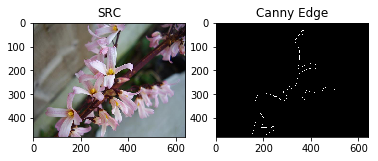

In [27]:
plt.subplot(121)
plt.imshow(src)
plt.title('SRC')
plt.subplot(122)
plt.imshow(cv2.convertScaleAbs(edge * 65535 / 255),'gray')
plt.title('Canny Edge')

In [28]:
DEGREE_0 = 0
DEGREE_45 = 45
DEGREE_90 = 90
DEGREE_135 = 135

THRESHOLD_LOW = 12
THRESHOLD_HIGH = 30

EDGE = 255
NOT_EDGE = 0

sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])

参考：

[1]. https://blog.csdn.net/trent1985/article/details/45095931

[2]. https://github.com/mubastan/canny